# Load Data

## Load Scores

In [1]:
import pandas as pd

df = pd.concat([
    pd.read_csv('scores-historical.csv.gz'),
    pd.read_csv('scores-2024.csv.gz'),
])
df.shape

(21217, 6)

In [2]:
df.head()

,home_team,away_team,game_pk,game_date,post_home_score,post_away_score
0,CHC,STL,413661,2015-04-05,0,3
1,AZ,SF,413669,2015-04-07,7,6
2,LAD,SD,413668,2015-04-07,3,7
3,MIA,ATL,413665,2015-04-07,2,12
4,MIL,COL,413667,2015-04-07,2,5


In [3]:
df['home_team_win'] = df.post_home_score > df.post_away_score
df['away_team_win'] = df.post_home_score < df.post_away_score
df['season_year'] = pd.to_datetime(df.game_date).dt.year
scores = df.groupby(['home_team', 'away_team', 'season_year'])[['home_team_win', 'away_team_win']].sum().reset_index()
scores['series_length'] = scores.home_team_win + scores.away_team_win
scores.home_team.unique()

array(['ATL', 'AZ', 'BAL', 'BOS', 'CHC', 'CIN', 'CLE', 'COL', 'CWS',
       'DET', 'HOU', 'KC', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'NYM',
       'NYY', 'OAK', 'PHI', 'PIT', 'SD', 'SEA', 'SF', 'STL', 'TB', 'TEX',
       'TOR', 'WSH'], dtype=object)

In [4]:
team_mapping = {t: i for i, t in enumerate(df.home_team.unique())}
scores['home_team_id'] = scores.home_team.map(team_mapping)
scores['away_team_id'] = scores.away_team.map(team_mapping)
scores

,home_team,away_team,season_year,home_team_win,away_team_win,series_length,home_team_id,away_team_id
0,ATL,AZ,2015,2,1,3,21,1
1,ATL,AZ,2016,0,3,3,21,1
2,ATL,AZ,2017,3,0,3,21,1
3,ATL,AZ,2018,1,2,3,21,1
4,ATL,AZ,2019,0,3,3,21,1
...,...,...,...,...,...,...,...,...
4968,WSH,TEX,2023,2,1,3,14,25
4969,WSH,TOR,2015,1,2,3,14,20
4970,WSH,TOR,2020,0,2,2,14,20
4971,WSH,TOR,2021,2,0,2,14,20


## Calculate Standings

This just serves as a sanity check that we loaded everything correctly

In [5]:
wins = (
    scores.groupby(['season_year', 'home_team']).home_team_win.sum().rename_axis(['season_year', 'team'])
    + scores.groupby(['season_year', 'away_team']).away_team_win.sum().rename_axis(['season_year', 'team'])
).rename('wins')

losses = (
    scores.groupby(['season_year', 'home_team']).away_team_win.sum().rename_axis(['season_year', 'team'])
    + scores.groupby(['season_year', 'away_team']).home_team_win.sum().rename_axis(['season_year', 'team'])
).rename('losses')

standings = pd.concat([wins, losses], axis=1).sort_index()
standings

wins  losses
season_year team              
2015        ATL     67      95
            AZ      79      83
            BAL     81      81
            BOS     78      84
            CHC     97      65
...                ...     ...
2024        STL     28      30
            TB      29      31
            TEX     29      31
            TOR     28      31
            WSH     27      32

[300 rows x 2 columns]

In [6]:
standings_2024 = standings.loc[2024].sort_values('wins', ascending=False)
standings_2024['games_played'] = standings_2024.sum(axis=1)
standings_2024

,wins,losses,games_played
team,,,
PHI,42,19,61
NYY,42,19,61
CLE,39,20,59
BAL,38,20,58
LAD,38,23,61
MIL,36,24,60
KC,36,25,61
SEA,34,27,61
MIN,33,26,59


In [7]:
standings.groupby('season_year').wins.sum() / standings.sum(axis=1).groupby('season_year').sum()

season_year
2015    0.5
2016    0.5
2017    0.5
2018    0.5
2019    0.5
2020    0.5
2021    0.5
2022    0.5
2023    0.5
2024    0.5
dtype: float64

## Load Power Rankings

In [8]:
power_rankings = pd.read_csv('power-rankings.csv').set_index('team')
power_rankings

,Rank,Team,Record,Elo,Opponent Elo,Playoff Odds,Power Score,Δ
team,,,,,,,,
NYY,1,Yankees,33-15,1607,1504,97.6%,1613,3
PHI,2,Phillies,34-14,1598,1471,97.7%,1607,1
LAD,3,Dodgers,32-17,1599,1493,99.4%,1606,-1
ATL,4,Braves,26-16,1589,1504,98.7%,1591,-3
BAL,5,Orioles,29-15,1576,1498,90.8%,1581,0
CLE,6,Guardians,30-17,1546,1486,55.0%,1553,5
KC,7,Royals,29-19,1532,1489,46.9%,1536,3
MIL,8,Brewers,27-19,1527,1502,68.7%,1532,-1
SEA,9,Mariners,25-22,1534,1507,59.0%,1532,0


## Load Fangraphs Projections

In [9]:
fangraphs_projections = pd.read_csv('fangraphs-projections.csv', header=[0, 1], index_col=0).rename_axis('Team')
fangraphs_projections

Unnamed: 0_level_0 2024 Year to Date                                  \
Team                               G   W   L     W% RDif  RS/G  RA/G   
Team                                                                   
Yankees                           55  37  18  0.673   92  4.84  3.16   
Phillies                          55  38  17  0.691   89  5.33  3.71   
Dodgers                           55  33  22  0.600   69  4.91  3.65   
Orioles                           52  34  18  0.654   69  5.06  3.73   
Braves                            51  30  21  0.588   43  4.63  3.78   
Guardians                         54  36  18  0.667   71  4.98  3.67   
Twins                             53  29  24  0.547    5  4.45  4.36   
Royals                            55  34  21  0.618   78  4.87  3.45   
Brewers                           53  31  22  0.585   49  4.96  4.04   
Mariners                          55  29  26  0.527   -6  3.73  3.84   
Padres                            57  29  28  0.509    9  4.39  4.23   
Astros                            54  24  30  0.444   -5  4.52  4.61   
Rays                              54  26  28  0.481  -47  3.96  4.83   
Giants                            55  28  27  0.509  -15  4.45  4.73   
Diamondbacks                      53  25  28  0.472    3  4.62  4.57   
Cubs                              54  27  27  0.500   -7  4.22  4.35   
Blue Jays                         53  24  29  0.453  -34  3.96  4.60   
Red Sox                           54  27  27  0.500   24  4.35  3.91   
Cardinals                         52  25  27  0.481  -43  3.87  4.69   
Tigers                            53  26  27  0.491    0  4.25  4.25   
Rangers                           54  25  29  0.463   -6  4.43  4.54   
Mets                              52  22  30  0.423  -24  4.27  4.73   
Pirates                           54  25  29  0.463  -29  3.96  4.50   
Reds                              54  24  30  0.444   -1  4.13  4.15   
Angels                            53  20  33  0.377  -36  4.34  5.02   
Nationals                         52  24  28  0.462  -14  4.08  4.35   
Athletics                         55  22  33  0.400  -63  3.75  4.89   
Marlins                           55  19  36  0.345  -79  3.67  5.11   
Rockies                           53  19  34  0.358  -72  4.13  5.49   
White Sox                         55  15  40  0.273 -120  2.87  5.05   

Unnamed: 0_level_0 2024 Projected Rest of Season                            \
Team                                           G   W   L     W% RDif  RS/G   
Team                                                                         
Yankees                                      107  59  48  0.553   54  4.73   
Phillies                                     107  57  50  0.535   35  4.53   
Dodgers                                      107  61  46  0.571   73  4.85   
Orioles                                      110  59  51  0.535   37  4.53   
Braves                                       111  61  50  0.552   54  4.67   
Guardians                                    108  53  55  0.487  -13  4.34   
Twins                                        109  58  51  0.529   29  4.36   
Royals                                       107  53  54  0.491   -9  4.44   
Brewers                                      109  55  54  0.500    0  4.41   
Mariners                                     107  56  51  0.521   20  4.21   
Padres                                       105  55  50  0.522   21  4.37   
Astros                                       108  59  49  0.549   51  4.75   
Rays                                         108  57  51  0.528   28  4.31   
Giants                                       107  54  53  0.509    8  4.17   
Diamondbacks                                 109  56  53  0.516   16  4.41   
Cubs                                         108  54  54  0.499   -1  4.40   
Blue Jays                                    109  57  52  0.521   21  4.43   
Red Sox                                      108  54  54  0.496

In [10]:
fangraphs_projections.set_index(
    fangraphs_projections.index.map({
        'Braves': 'ATL',
        'Dodgers': 'LAD',
        'Phillies': 'PHI',
        'Yankees': 'NYY',
        'Orioles': 'BAL',
        'Twins': 'MIN',
        'Brewers': 'MIL',
        'Cubs': 'CHC',
        'Mariners': 'SEA',
        'Royals': 'KC',
        'Guardians': 'CLE',
        'Padres': 'SD',
        'Red Sox': 'BOS',
        'Mets': 'NYM',
        'Rangers': 'TEX',
        'Diamondbacks': 'AZ',
        'Rays': 'TB',
        'Blue Jays': 'TOR',
        'Astros': 'HOU',
        'Tigers': 'DET',
        'Giants': 'SF',
        'Athletics': 'OAK',
        'Nationals': 'WSH',
        'Cardinals': 'STL',
        'Reds': 'CIN',
        'Pirates': 'PIT',
        'Angels': 'LAA',
        'Marlins': 'MIA',
        'White Sox': 'CWS',
        'Rockies': 'COL'
    }).rename('team'),
    inplace=True
)

In [11]:
fangraphs_projections['2024 Projected Full Season']

Team,W,L,W%,RDif,RS/G,RA/G
team,,,,,,
NYY,96,66,0.593,146,4.77,3.86
PHI,95,67,0.588,124,4.80,4.03
LAD,94,68,0.581,142,4.87,3.99
BAL,93,69,0.573,106,4.70,4.05
ATL,91,71,0.563,97,4.66,4.06
CLE,89,73,0.547,58,4.55,4.20
MIN,87,75,0.535,34,4.39,4.18
KC,87,75,0.534,69,4.59,4.17
MIL,86,76,0.528,49,4.59,4.29


## Load Schedule

In [12]:
schedule = pd.read_csv('schedule-2024.csv')
schedule.shape

(2428, 5)

In [13]:
# https://www.mlbschedulegrid.com/rainouts
rain_outs = pd.DataFrame([
    ['2024-05-28', 'NYM', 'LAD'],
    ['2024-06-27', 'CWS', 'ATL'],
    ['2024-08-09', 'MIN', 'CLE'],
    ['2024-09-26', 'ATL', 'NYM'],
    ['2024-08-30', 'CIN', 'MIL'],
    ['2024-08-05', 'STL', 'NYM'],
    ['2024-07-29', 'BAL', 'TOR'],
    ['2024-07-13', 'CHC', 'STL'],
], columns=['date', 'home_team', 'away_team'])
rain_outs['dh'] = 1
rain_outs.shape

(8, 4)

In [14]:
schedule = pd.concat([schedule, rain_outs])
schedule.shape

(2436, 5)

In [15]:
schedule['home_team_id'] = schedule.home_team.map(team_mapping)
schedule['away_team_id'] = schedule.away_team.map(team_mapping)
schedule

,date,time,home_team,away_team,dh,home_team_id,away_team_id
0,2024-04-05,6:38 PM,LAA,BOS,1.0,29,23
1,2024-04-06,6:38 PM,LAA,BOS,1.0,29,23
2,2024-04-07,1:07 PM,LAA,BOS,1.0,29,23
3,2024-04-08,6:38 PM,LAA,TB,1.0,29,7
4,2024-04-09,6:38 PM,LAA,TB,1.0,29,7
...,...,...,...,...,...,...,...
3,2024-09-26,NaN,ATL,NYM,1.0,21,17
4,2024-08-30,NaN,CIN,MIL,1.0,8,4
5,2024-08-05,NaN,STL,NYM,1.0,19,17
6,2024-07-29,NaN,BAL,TOR,1.0,22,20


# Define Model

In [16]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt


def softmax(a):
    # reshaping for broadcasting
    a = pt.exp(a)
    sum_ = pt.sum(a, axis=1)[None, :].T
    return a / sum_


def Model(year_id, home_team_id, away_team_id, N, game_outcomes):
    with pm.Model() as model:
        n_years = year_id.nunique()
        n_teams = home_team_id.nunique()
        year_id = pm.MutableData('year_id', year_id)
        home_team_id = pm.MutableData('home_team_id', home_team_id)
        away_team_id = pm.MutableData('away_team_id', away_team_id)
        N = pm.MutableData('N', N, dims='series')
        
        σ_a_μ = pm.Gamma('σ_a_μ', mu=np.log(5), sigma=np.log(5)/4)
        σ_a_σ = pm.Gamma('σ_a_σ', mu=np.log(5)/4, sigma=np.log(5)/8)
        σ_a = pm.Gamma('σ_a', mu=σ_a_μ, sigma=σ_a_σ)
    
        a_t = pm.Normal('a_t', mu=0, sigma=σ_a, shape=(n_years, n_teams))
        a_1, a_2 = a_t[year_id, home_team_id], a_t[year_id, away_team_id]
        a = pt.stack([a_1, a_2]).T
    
        p = pm.Deterministic('p', softmax(a))
        wins = pm.Multinomial(
            'wins',
            n=N,
            p=p,
            observed=game_outcomes,
            dims='series'
        )
    return model

## Fit

In [17]:
X = scores.copy()
X

,home_team,away_team,season_year,home_team_win,away_team_win,series_length,home_team_id,away_team_id
0,ATL,AZ,2015,2,1,3,21,1
1,ATL,AZ,2016,0,3,3,21,1
2,ATL,AZ,2017,3,0,3,21,1
3,ATL,AZ,2018,1,2,3,21,1
4,ATL,AZ,2019,0,3,3,21,1
...,...,...,...,...,...,...,...,...
4968,WSH,TEX,2023,2,1,3,14,25
4969,WSH,TOR,2015,1,2,3,14,20
4970,WSH,TOR,2020,0,2,2,14,20
4971,WSH,TOR,2021,2,0,2,14,20


In [18]:
year_id = X.season_year - X.season_year.min()
home_team_id = X.home_team_id
away_team_id = X.away_team_id
n_matchups = X.series_length
observed_wins = X[['home_team_win', 'away_team_win']]

model = Model(
    year_id=year_id,
    home_team_id=home_team_id,
    away_team_id=away_team_id,
    N=n_matchups,
    game_outcomes=observed_wins
)

### Sample Priors

Sampling: [a_t, wins, σ_a, σ_a_μ, σ_a_σ]


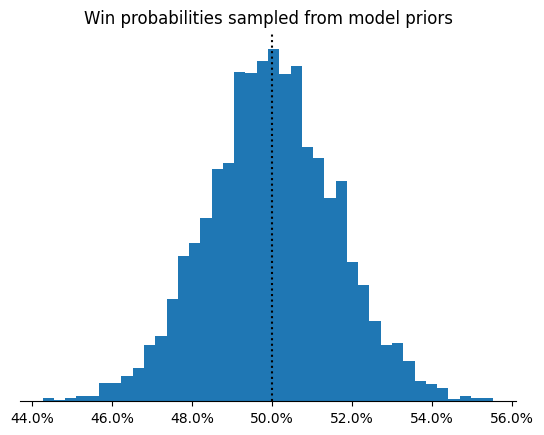

In [19]:
import matplotlib.pyplot as plt

with model:
    priors = pm.sample_prior_predictive()

fig, ax = plt.subplots()
prior_wins = priors.prior_predictive.wins
ax.hist((prior_wins.sum(axis=(0, 1)) / prior_wins.sum(axis=(0, 1, 3)))[:, 0], bins=40)

ax.set_title('Win probabilities sampled from model priors')
ax.xaxis.set_major_formatter('{x:.1%}')
ax.set_yticks([])
for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

ax.axvline(.5, ls=':', color='k')

# fig.savefig('assets/priors-win-probability.png', dpi=300)

### Sample Posterior

In [20]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_a_μ, σ_a_σ, σ_a, a_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


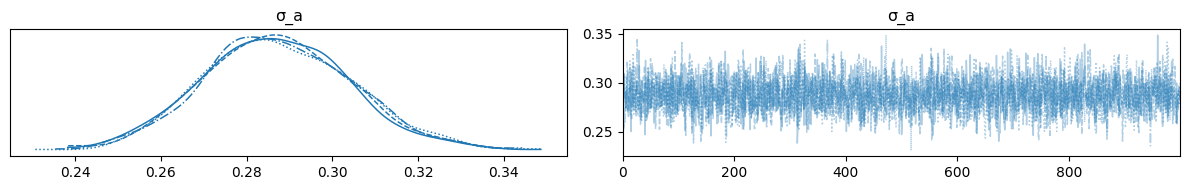

In [21]:
import arviz as az
import matplotlib.pyplot as plt

az.plot_trace(idata, var_names=['σ_a'])
plt.tight_layout()

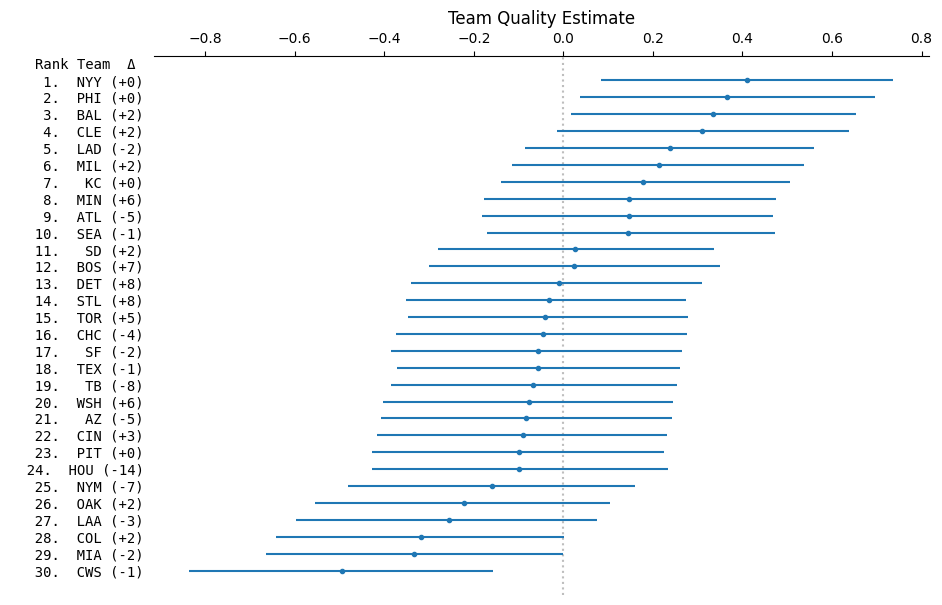

In [22]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 7))

a_t = idata.posterior.a_t.values[..., -1, :]
μ = a_t.mean(axis=(0, 1))
lower, upper = np.quantile(a_t, [.05, .95], axis=(0, 1))
team_id_lookup = {v: k for k, v in team_mapping.items()}

for i, team_ix in enumerate(np.argsort(μ)[::-1]):
    team = team_id_lookup[i]
    ax.scatter(μ[team_ix], 30-i, color='C0', marker='.')
    ax.hlines(
        30-i,
        lower[team_ix],
        upper[team_ix],
        color='C0'
    )

ax.set_title('Team Quality Estimate')
y_ticklabels = [
    (i+1, team_id_lookup[team_ix], power_rankings.loc[team_id_lookup[team_ix]].Rank)
    for i, team_ix in enumerate(np.argsort(μ)[::-1])
]
ax.set_yticks(
    31-np.arange(31),
    ['Rank Team  Δ '] + [
        f'{rank:>4}. {team:>4} {f"({power_ranking-rank:+})":>4}'
        for rank, team, power_ranking in y_ticklabels
    ],
    fontname='monospace'
)
plt.tick_params(axis='y', which='both', left=False)
for spine in ['left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)
ax.xaxis.tick_top()

ax.axvline(0, color='C7', ls=':', zorder=-1, alpha=.5)

### Forecast Remainder of Schedule

In [23]:
schedule.head()

,date,time,home_team,away_team,dh,home_team_id,away_team_id
0,2024-04-05,6:38 PM,LAA,BOS,1.0,29,23
1,2024-04-06,6:38 PM,LAA,BOS,1.0,29,23
2,2024-04-07,1:07 PM,LAA,BOS,1.0,29,23
3,2024-04-08,6:38 PM,LAA,TB,1.0,29,7
4,2024-04-09,6:38 PM,LAA,TB,1.0,29,7


In [24]:
X_forecast = (
    schedule
    [schedule.date.gt(df.game_date.max())]
    .groupby(['home_team', 'home_team_id', 'away_team', 'away_team_id'])
    .dh
    .sum()
    .astype(int)
    .rename('n')
    .reset_index()
)
X_forecast

,home_team,home_team_id,away_team,away_team_id,n
0,ATL,21,CIN,8,3
1,ATL,21,COL,27,3
2,ATL,21,DET,9,3
3,ATL,21,KC,11,3
4,ATL,21,LAD,2,4
...,...,...,...,...,...
455,WSH,14,NYY,12,3
456,WSH,14,PHI,13,3
457,WSH,14,SD,15,3
458,WSH,14,SF,18,4


In [25]:
assert (
    standings.loc[2024].sum(axis=1)
    + X_forecast.groupby('home_team').n.sum()
    + X_forecast.groupby('away_team').n.sum()
).eq(162).all()

In [26]:
with model:
    pm.set_data(dict(
        year_id=np.array([max(X.season_year - X.season_year.min())], dtype=int),
        home_team_id=X_forecast.home_team_id,
        away_team_id=X_forecast.away_team_id,
        N=X_forecast.n
    ))
    forecast = pm.sample_posterior_predictive(idata, predictions=True)

Sampling: [wins]


In [27]:
forecasted_schedule = pd.concat([
    pd.DataFrame(
        forecast.predictions.wins[..., axis].values.reshape(-1, len(X_forecast)).T,
        index=X_forecast[c].rename('team')
    )
    for c, axis in zip(['home_team', 'away_team'], [0, 1])
])
forecasted_schedule.shape

(920, 4000)

In [28]:
forecasted_wins = forecasted_schedule.groupby('team').sum()
forecasted_wins.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
team,,,,,,,,,,,,,,,,,,,,,
ATL,59,54,52,50,70,47,54,62,63,53,...,47,57,52,61,58,60,50,48,57,57
AZ,44,43,50,50,45,54,63,54,50,54,...,49,60,39,47,53,54,60,48,49,52
BAL,52,63,55,57,66,51,50,65,51,74,...,64,52,58,64,53,53,59,64,53,64
BOS,45,48,61,55,42,54,55,39,58,52,...,57,49,48,57,53,55,43,61,47,55
CHC,48,58,58,59,43,43,52,53,45,56,...,43,60,49,48,42,53,41,73,28,60


In [29]:
forecasted_wins = forecasted_wins.add(standings.loc[2024].wins, axis=0)
forecasted_wins.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
team,,,,,,,,,,,,,,,,,,,,,
ATL,92,87,85,83,103,80,87,95,96,86,...,80,90,85,94,91,93,83,81,90,90
AZ,72,71,78,78,73,82,91,82,78,82,...,77,88,67,75,81,82,88,76,77,80
BAL,90,101,93,95,104,89,88,103,89,112,...,102,90,96,102,91,91,97,102,91,102
BOS,75,78,91,85,72,84,85,69,88,82,...,87,79,78,87,83,85,73,91,77,85
CHC,77,87,87,88,72,72,81,82,74,85,...,72,89,78,77,71,82,70,102,57,89


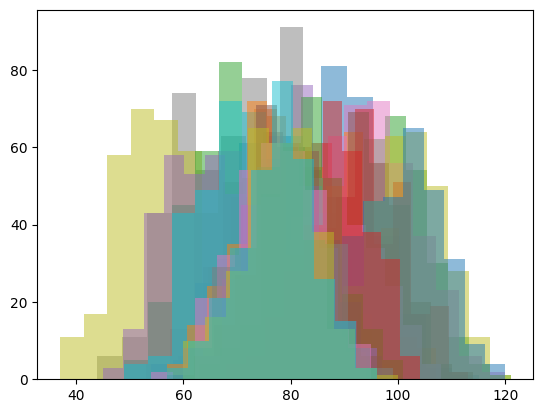

In [30]:
for L, r in forecasted_wins.sample(300, axis=1).iterrows():
    plt.hist(r, alpha=.5)

In [31]:
assert (forecasted_wins.sum(axis=0) == (162 * 15)).all(), 'not forecasting complete season'

NameError: name 'ax2' is not defined

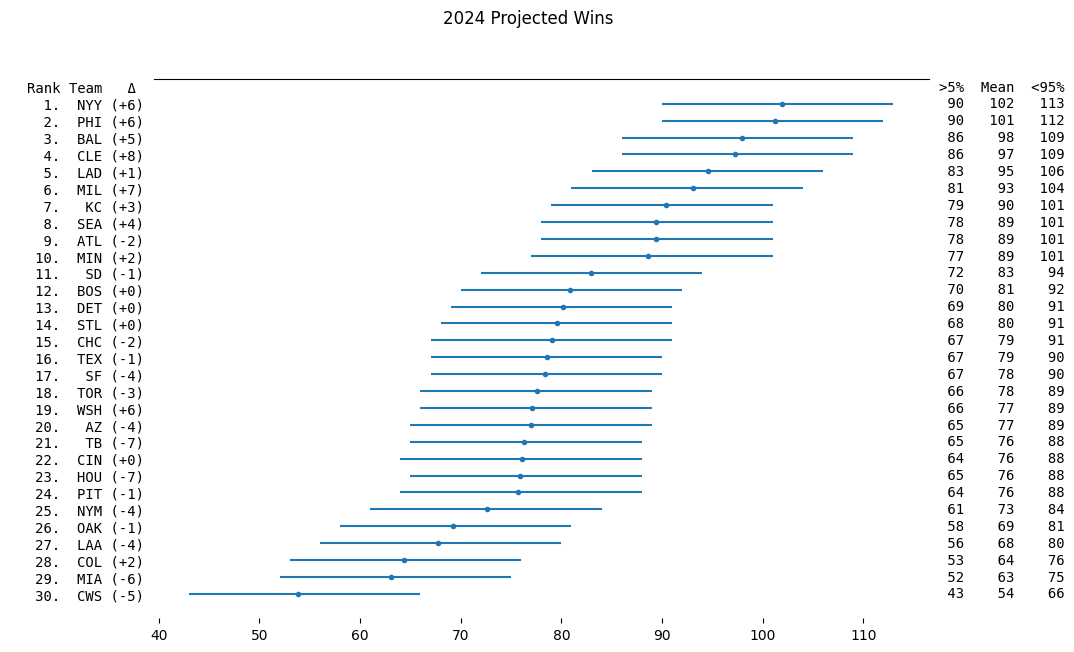

In [32]:
import textwrap

import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 7))

a_t = forecasted_wins
μ = a_t.mean(axis=1)
quantiles = a_t.quantile([.05, .95], axis=1).T
team_id_lookup = {v: k for k, v in team_mapping.items()}

y_ticklabels_left = []
y_ticklabels_right = []
for i, team in enumerate(μ.sort_values(ascending=False).index):
    lower, upper = quantiles.loc[team, .05], quantiles.loc[team, .95]
    ax.scatter(μ[team], 30-i, color='C0', marker='.')
    ax.hlines(
        30-i,
        lower,
        upper,
        color='C0'
    )
    y_ticklabels_left.append((i+1, team, μ[team], fangraphs_projections['2024 Projected Full Season']['W'].loc[team]))
    y_ticklabels_right.append((lower, upper, μ[team]))

fig.suptitle('2024 Projected Wins')

# ax.sharey(ax2)
ax.set_yticks(
    31-np.arange(31),
    ['Rank Team   Δ '] + [
        f' {rank:>4}. {team:>4} {f"({round(μi-power_ranking):+})":>4}'
        for rank, team, μi, power_ranking in y_ticklabels_left
    ],
    fontname='monospace'    
)

ax.annotate('>5%  Mean  <95%', (1.04*quantiles[.95].max(), 31), fontname='monospace', va='center', annotation_clip=False)
for yi, (L, U, μi) in zip(30-np.arange(30), y_ticklabels_right):
    ax.annotate(f'{L:>3.0f}   {μi:>3.0f}   {U:>3.0f}', (1.04*quantiles[.95].max(), yi), fontname='monospace', va='center', annotation_clip=False)

plt.tick_params(axis='y', which='both', left=False)
for spine in ['left', 'bottom', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ax2.spines:
    ax2.spines[spine].set_visible(False)
ax.xaxis.tick_top()

_ = ax.annotate(
    '\n'.join(
        textwrap.wrap(' '.join(
            f'''
            Projected wins for all 30 MLB teams in the 2024 season,
            using game outcomes through {df.game_date.max()}. Range
            represents 90% credible interval taken from posterior samples.
            Delta represents the difference in our projections vs. FanGraphs
            projections over the same date.
            '''.strip().split()
        ), width=110)
    ),
    (.5, -.04),
    xycoords='axes fraction',
    ha='center',
    va='center',
)

# fig.savefig('assets/projections.png', dpi=300, bbox_inches='tight')